In [6]:
import pandas as pd 
import ollama
import json
from tqdm import tqdm

In [7]:
file_path='diabetes_input.csv'
df=pd.read_csv(file_path)

In [8]:
tqdm.pandas(desc="Processing Rows")

In [9]:
def predict_diabetes(data_row):
    prompt = f"""
    Based on the following patient medical data, predict if the person has diabetes (1) or not (0):
    
    Pregnancies: {data_row['Pregnancies']}
    Glucose: {data_row['Glucose']}
    BloodPressure: {data_row['BloodPressure']}
    SkinThickness: {data_row['SkinThickness']}
    Insulin: {data_row['Insulin']}
    BMI: {data_row['BMI']}
    DiabetesPedigreeFunction: {data_row['DiabetesPedigreeFunction']}
    Age: {data_row['Age']}

    Respond with only a single number: 1 for diabetic, 0 for non-diabetic.
    """

    response = ollama.chat(model="llama3.1:latest", messages=[{"role": "user", "content": prompt}])
    result = response["message"]["content"].strip()

    # Ensure the result is either 0 or 1
    try:
        return int(result) if result in ["0", "1"] else None
    except ValueError:
        return None

In [10]:
df["Predicted_Outcome"] = df.progress_apply(predict_diabetes, axis=1)

# Save the predictions to a new CSV file
output_file = "diabetes_predictions_llama3.1.csv"
df.to_csv(output_file, index=False)

print(f"Predictions saved to {output_file}")

Processing Rows:  51%|█████     | 392/768 [1:28:55<1:25:17, 13.61s/it]


KeyboardInterrupt: 


Confusion Matrix for diabetes_predictions_mistral_one_shot:
[[ 31 469]
 [  0 268]]


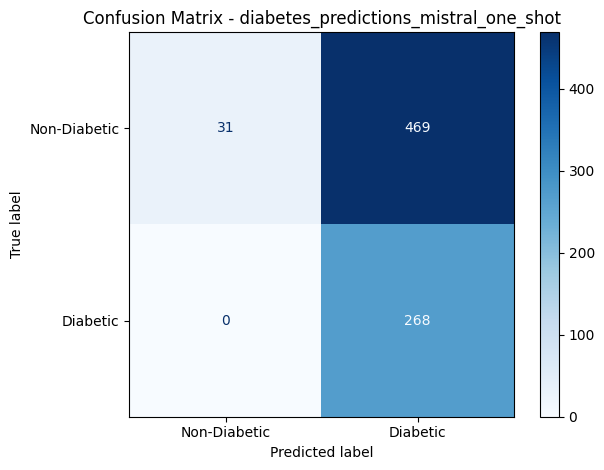


Confusion Matrix for diabetes_predictions_mistral_three_shot:
[[218 282]
 [ 24 244]]


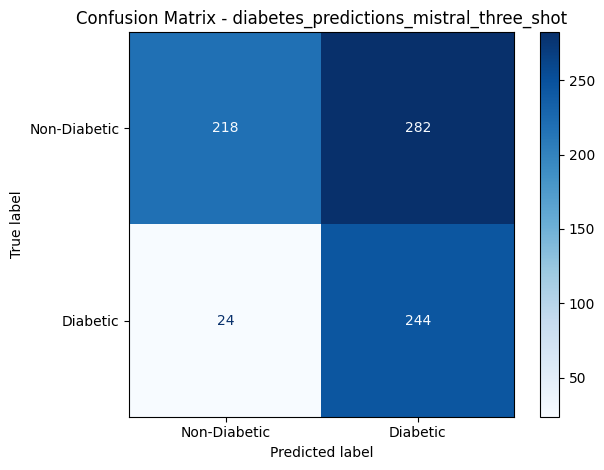


Confusion Matrix for diabetes_predictions_mistral_zero_shot:
[[ 55 445]
 [  1 267]]


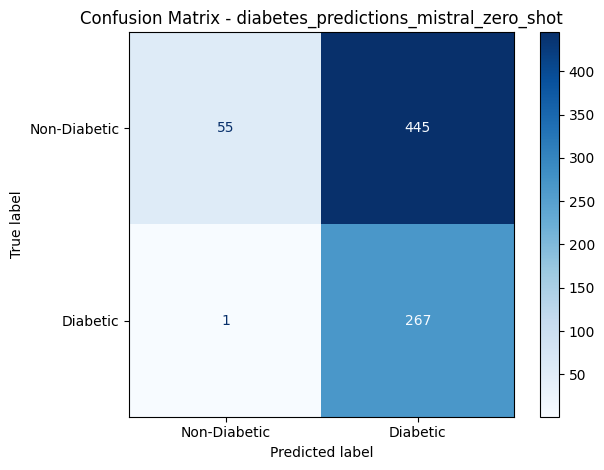


Confusion Matrix for diabetes_predictions_llama3.2_zero_shot:
[[  1 499]
 [  0 268]]


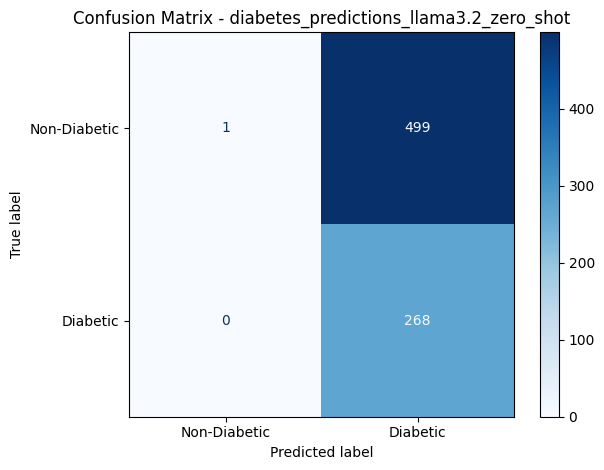


Confusion Matrix for diabetes_predictions_llama3.2_three_shot:
[[ 19 481]
 [  3 265]]


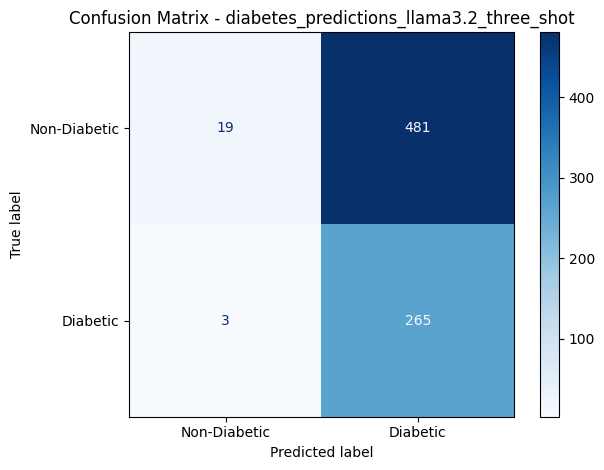


Confusion Matrix for diabetes_predictions_llama3.2_one_shot:
[[  4 496]
 [  0 268]]


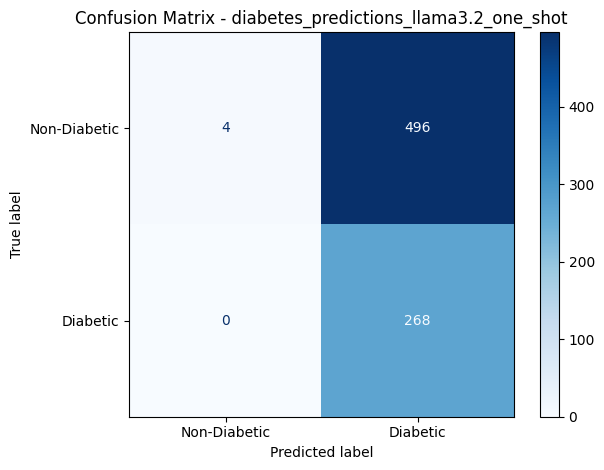


Confusion Matrix for diabetes_predictions_llama3.1_zero_shot:
[[ 14 486]
 [  2 266]]


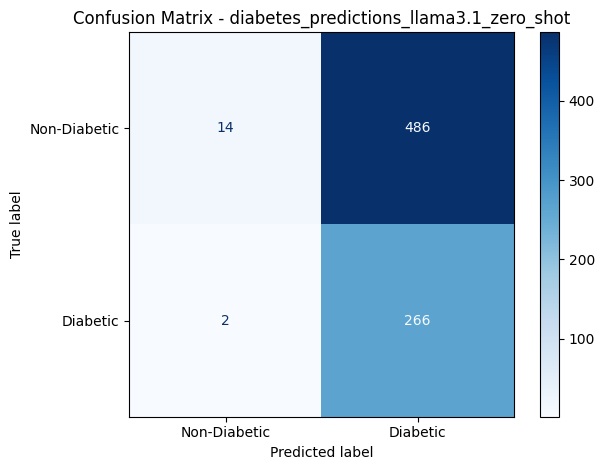


Confusion Matrix for diabetes_predictions_llama3.1_three_shot:
[[  6 494]
 [  0 268]]


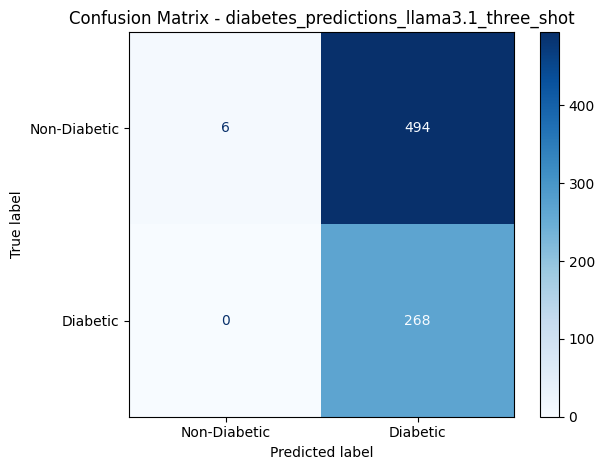


Confusion Matrix for diabetes_predictions_llama3.1_one_shot:
[[  2 498]
 [  0 268]]


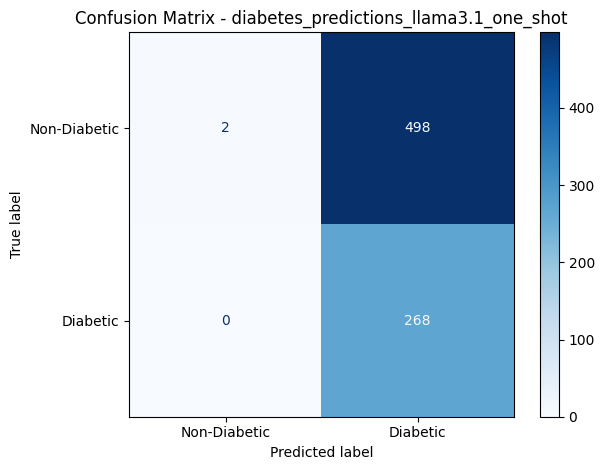


Confusion Matrix for diabetes_predictions_gemma2_zero_shot:
[[340 160]
 [ 55 213]]


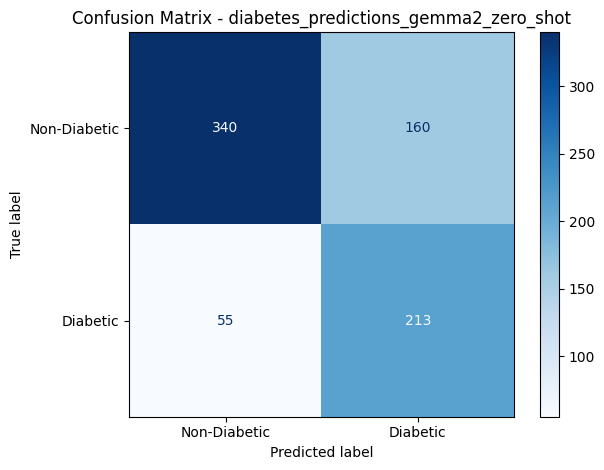


Confusion Matrix for diabetes_predictions_gemma2_three_shot:
[[385 115]
 [ 82 186]]


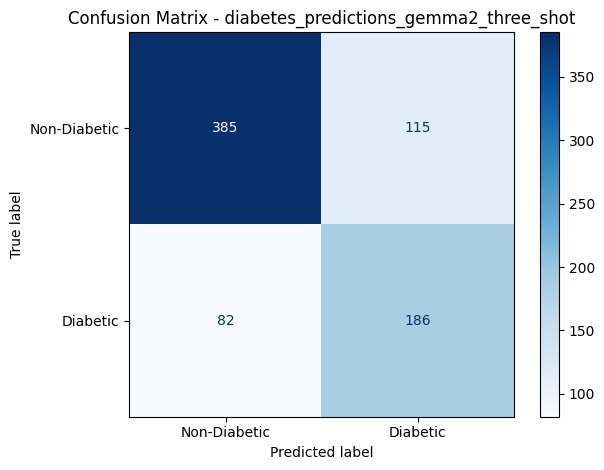


Confusion Matrix for diabetes_predictions_gemma2_one_shot:
[[250 250]
 [ 15 253]]


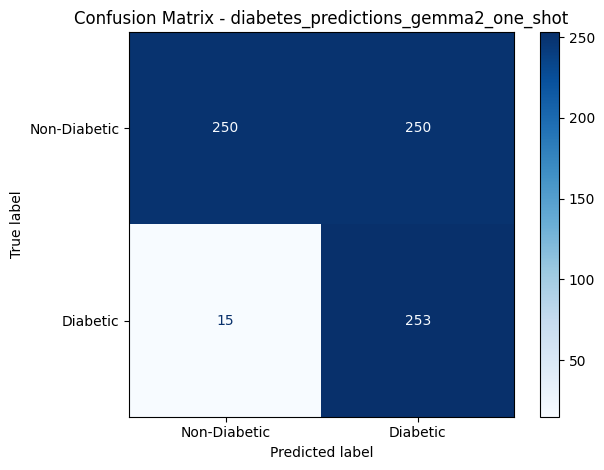

ValueError: too many values to unpack (expected 4)

In [6]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Base path
base_path = "/Users/shadmansakib/Documents/Diabetes_Prediction/Diabetes_Prediction"
ground_truth_df = pd.read_csv(os.path.join(base_path, "diabetes.csv"))
true_labels = ground_truth_df["Outcome"].values

# Model prediction paths
prediction_paths = [
    "models/mistral/diabetes_predictions_mistral_one_shot.csv",
    "models/mistral/diabetes_predictions_mistral_three_shot.csv",
    "models/mistral/diabetes_predictions_mistral_zero_shot.csv",
    "models/llama3.2/diabetes_predictions_llama3.2_zero_shot.csv",
    "models/llama3.2/diabetes_predictions_llama3.2_three_shot.csv",
    "models/llama3.2/diabetes_predictions_llama3.2_one_shot.csv",
    "models/llama3.1/diabetes_predictions_llama3.1_zero_shot.csv",
    "models/llama3.1/diabetes_predictions_llama3.1_three_shot.csv",
    "models/llama3.1/diabetes_predictions_llama3.1_one_shot.csv",
    "models/gemma/diabetes_predictions_gemma2_zero_shot.csv",
    "models/gemma/diabetes_predictions_gemma2_three_shot.csv",
    "models/gemma/diabetes_predictions_gemma2_one_shot.csv",
    "models/gemini/diabetes_predictions_gemini_zero_shot.csv",
    "models/gemini/diabetes_predictions_gemini_three_shot.csv",
    "models/gemini/diabetes_predictions_gemini_one_shot.csv",
    "models/chatgpt/diabetes_predictions_chatgpt_three_shot.csv",
    "models/chatgpt/diabetes_predictions_chatgpt_zero_shot.csv",
    "models/chatgpt/diabetes_predictions_chatgpt_one_shot.csv",
]

# Initialize summaries
summary_data = []
all_preds = []
all_trues = []

# Process each prediction file
for rel_path in prediction_paths:
    full_path = os.path.join(base_path, rel_path)
    model_name = os.path.basename(full_path).replace(".csv", "")

    # Load prediction CSV
    try:
        pred_df = pd.read_csv(full_path)
        pred_labels = pred_df["Predicted_Outcome"].astype(int).values
    except Exception as e:
        print(f"[ERROR] Could not load or parse {model_name}: {e}")
        continue

    # Validate shape
    if len(pred_labels) != len(true_labels):
        print(f"[ERROR] Length mismatch for {model_name}. Skipping.")
        continue

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel()

    print(f"\nConfusion Matrix for {model_name}:\n{cm}")

    # Append summary row
    summary_data.append({
        "Model": model_name,
        "True Positives": tp,
        "False Positives": fp,
        "True Negatives": tn,
        "False Negatives": fn
    })

    # Save for combined matrix
    all_preds.extend(pred_labels)
    all_trues.extend(true_labels)

    # Plot individual heatmap
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Diabetic", "Diabetic"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.tight_layout()
    plt.show()

# Save per-model confusion summary
summary_df = pd.DataFrame(summary_data)
summary_csv = os.path.join(base_path, "confusion_matrix_summary.csv")
summary_df.to_csv(summary_csv, index=False)
print(f"\n✅ Per-model confusion summary saved to: {summary_csv}")

# -------------------------
# Combined Confusion Matrix
# -------------------------
combined_cm = confusion_matrix(all_trues, all_preds)
tn_c, fp_c, fn_c, tp_c = combined_cm.ravel()

print("\n=== Combined Confusion Matrix (All Predictions) ===")
print(combined_cm)

# Display combined heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=combined_cm, display_labels=["Non-Diabetic", "Diabetic"])
disp.plot(cmap="Oranges")
plt.title("Combined Confusion Matrix - All Models")
plt.tight_layout()
plt.show()

# Save combined summary
combined_summary = pd.DataFrame([{
    "Total True Positives": tp_c,
    "Total False Positives": fp_c,
    "Total True Negatives": tn_c,
    "Total False Negatives": fn_c
}])
combined_csv = os.path.join(base_path, "combined_confusion_matrix_summary.csv")
combined_summary.to_csv(combined_csv, index=False)
print(f"✅ Combined confusion summary saved to: {combined_csv}")


In [3]:
! pip install matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/7a/81/dae7e14042e74da658c3336ab9799128e09a1ee03964f2d89630b5d12106/matplotlib-3.10.1-cp312-cp312-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/93/3b/0004767622a9826ea3d95f0e9d98cd8729015768075d61f9fea8eeca42a8/contourpy-1.3.2-cp312-cp312-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/cb/98/d4bc42d43392982eecaaca117d79845734d675219680cd43070bb001bc1f/fonttools-4.57.0-cp312-cp312-macosx_10_13_universal2.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 240.6 kB/s eta 0:00:00a 0:00:01
  Obtaining dependenc


Confusion Matrix for diabetes_predictions_mistral_one_shot:
[[ 31 469]
 [  0 268]]


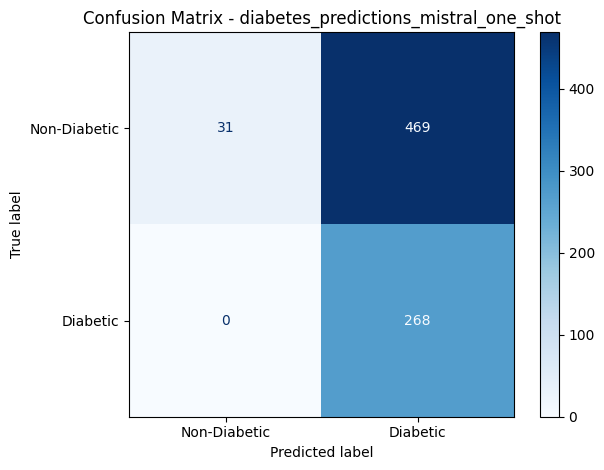


Confusion Matrix for diabetes_predictions_mistral_three_shot:
[[218 282]
 [ 24 244]]


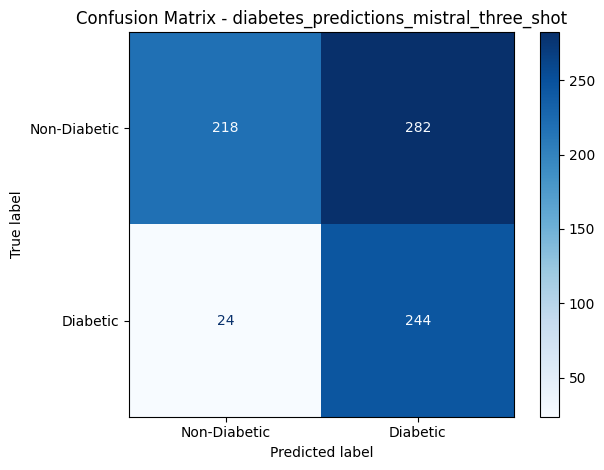


Confusion Matrix for diabetes_predictions_mistral_zero_shot:
[[ 55 445]
 [  1 267]]


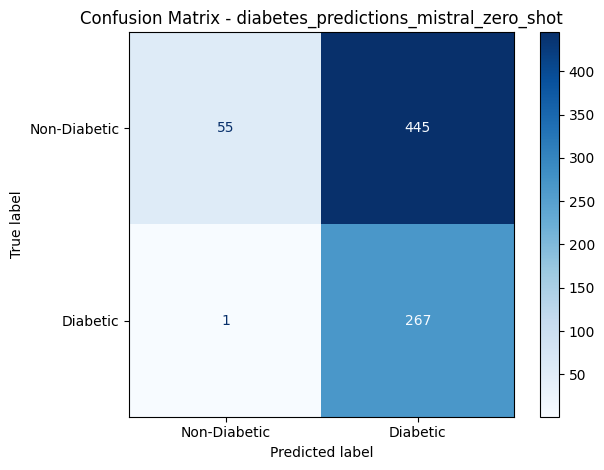


Confusion Matrix for diabetes_predictions_llama3.2_zero_shot:
[[  1 499]
 [  0 268]]


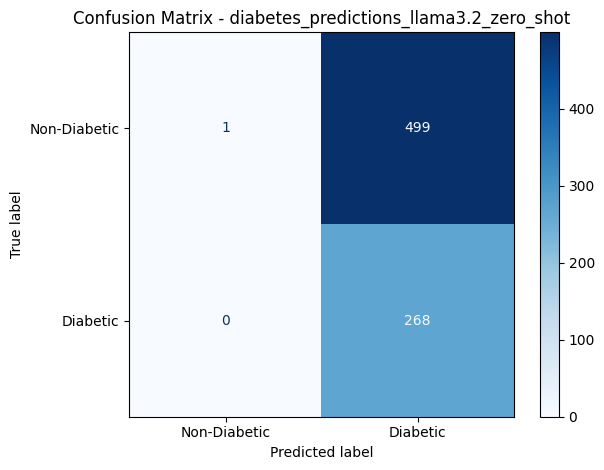


Confusion Matrix for diabetes_predictions_llama3.2_three_shot:
[[ 19 481]
 [  3 265]]


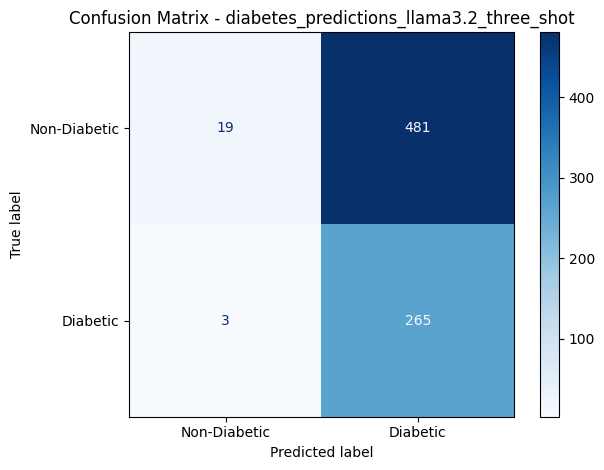


Confusion Matrix for diabetes_predictions_llama3.2_one_shot:
[[  4 496]
 [  0 268]]


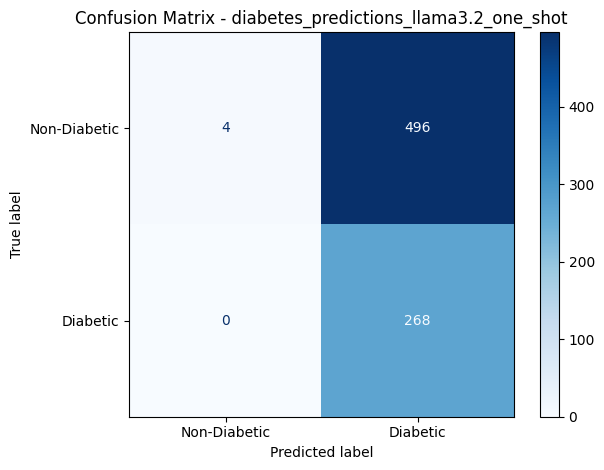


Confusion Matrix for diabetes_predictions_llama3.1_zero_shot:
[[ 14 486]
 [  2 266]]


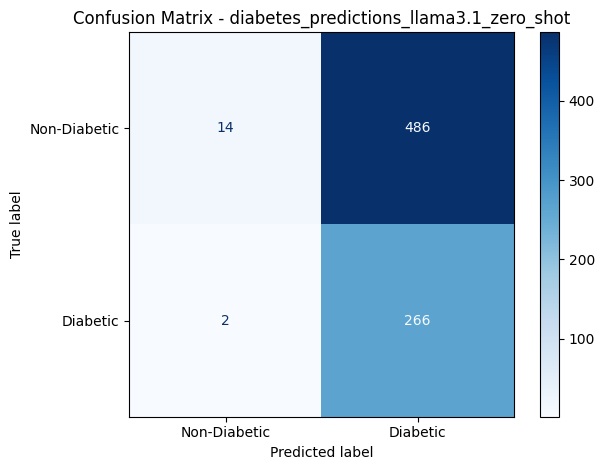


Confusion Matrix for diabetes_predictions_llama3.1_three_shot:
[[  6 494]
 [  0 268]]


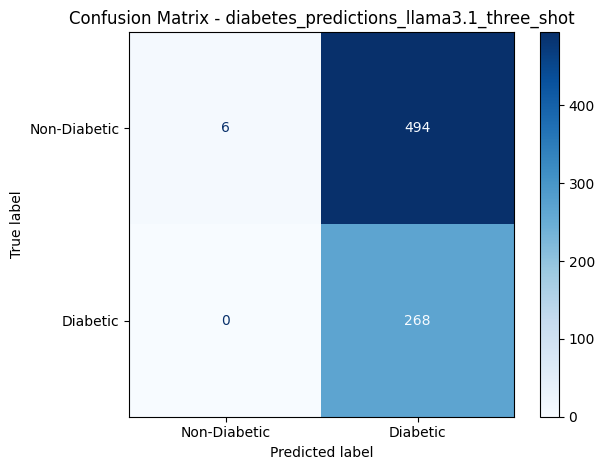


Confusion Matrix for diabetes_predictions_llama3.1_one_shot:
[[  2 498]
 [  0 268]]


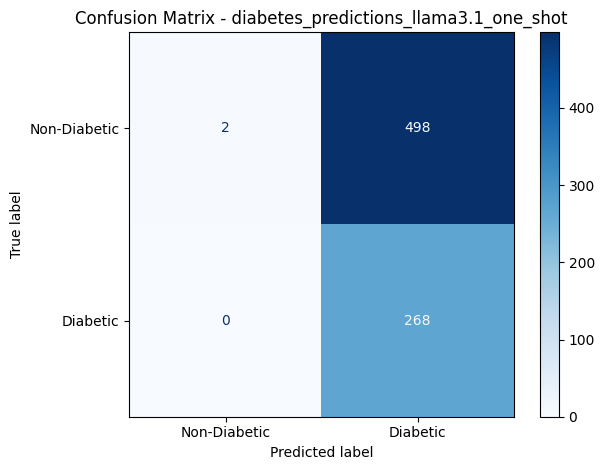


Confusion Matrix for diabetes_predictions_gemma2_zero_shot:
[[340 160]
 [ 55 213]]


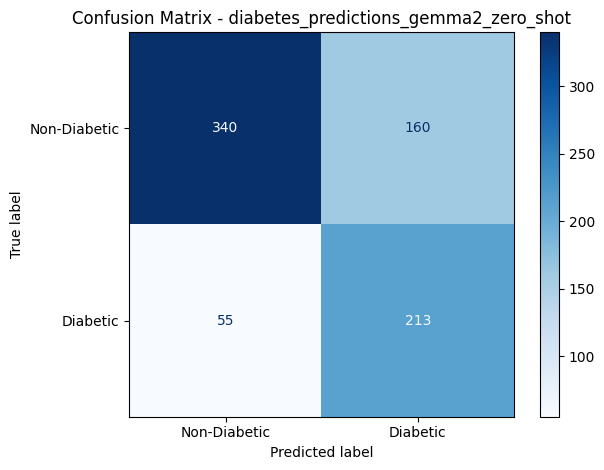


Confusion Matrix for diabetes_predictions_gemma2_three_shot:
[[385 115]
 [ 82 186]]


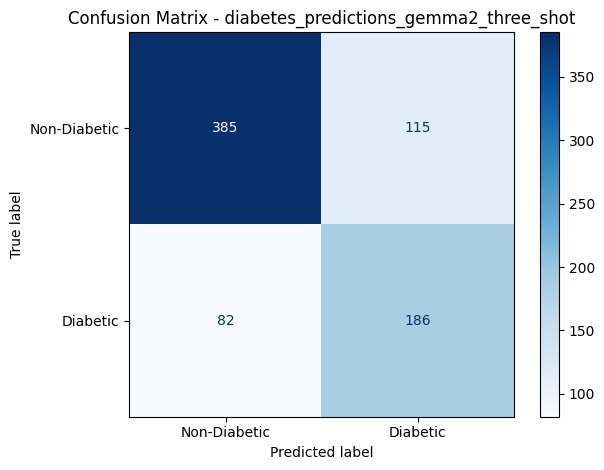


Confusion Matrix for diabetes_predictions_gemma2_one_shot:
[[250 250]
 [ 15 253]]


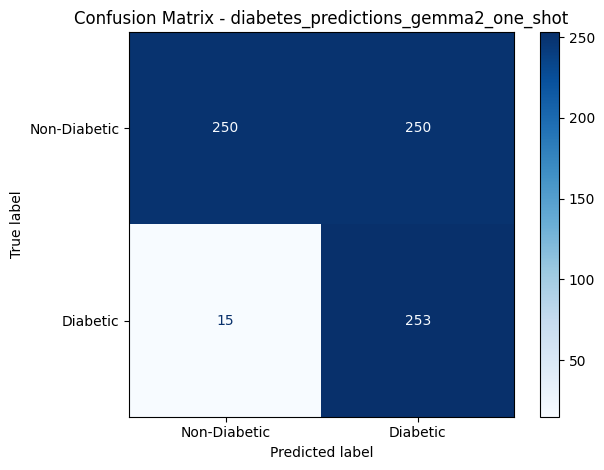

ValueError: too many values to unpack (expected 4)

In [7]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Base path
base_path = "/Users/shadmansakib/Documents/Diabetes_Prediction/Diabetes_Prediction"
ground_truth_df = pd.read_csv(os.path.join(base_path, "diabetes.csv"))
true_labels = ground_truth_df["Outcome"].values

# Model prediction paths
prediction_paths = [
    "models/mistral/diabetes_predictions_mistral_one_shot.csv",
    "models/mistral/diabetes_predictions_mistral_three_shot.csv",
    "models/mistral/diabetes_predictions_mistral_zero_shot.csv",
    "models/llama3.2/diabetes_predictions_llama3.2_zero_shot.csv",
    "models/llama3.2/diabetes_predictions_llama3.2_three_shot.csv",
    "models/llama3.2/diabetes_predictions_llama3.2_one_shot.csv",
    "models/llama3.1/diabetes_predictions_llama3.1_zero_shot.csv",
    "models/llama3.1/diabetes_predictions_llama3.1_three_shot.csv",
    "models/llama3.1/diabetes_predictions_llama3.1_one_shot.csv",
    "models/gemma/diabetes_predictions_gemma2_zero_shot.csv",
    "models/gemma/diabetes_predictions_gemma2_three_shot.csv",
    "models/gemma/diabetes_predictions_gemma2_one_shot.csv",
    "models/gemini/diabetes_predictions_gemini_zero_shot.csv",
    "models/gemini/diabetes_predictions_gemini_three_shot.csv",
    "models/gemini/diabetes_predictions_gemini_one_shot.csv",
    "models/chatgpt/diabetes_predictions_chatgpt_three_shot.csv",
    "models/chatgpt/diabetes_predictions_chatgpt_zero_shot.csv",
    "models/chatgpt/diabetes_predictions_chatgpt_one_shot.csv",
]

# Initialize summaries
summary_data = []
all_preds = []
all_trues = []

# Process each prediction file
for rel_path in prediction_paths:
    full_path = os.path.join(base_path, rel_path)
    model_name = os.path.basename(full_path).replace(".csv", "")

    # Load prediction CSV
    try:
        pred_df = pd.read_csv(full_path)
        pred_labels = pred_df["Predicted_Outcome"].astype(int).values
    except Exception as e:
        print(f"[ERROR] Could not load or parse {model_name}: {e}")
        continue

    # Validate shape
    if len(pred_labels) != len(true_labels):
        print(f"[ERROR] Length mismatch for {model_name}. Skipping.")
        continue

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel()

    print(f"\nConfusion Matrix for {model_name}:\n{cm}")

    # Append summary row
    summary_data.append({
        "Model": model_name,
        "True Positives": tp,
        "False Positives": fp,
        "True Negatives": tn,
        "False Negatives": fn
    })

    # Save for combined matrix
    all_preds.extend(pred_labels)
    all_trues.extend(true_labels)

    # Plot individual heatmap
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Diabetic", "Diabetic"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.tight_layout()
    plt.show()

# Save per-model confusion summary
summary_df = pd.DataFrame(summary_data)
summary_csv = os.path.join(base_path, "confusion_matrix_summary.csv")
summary_df.to_csv(summary_csv, index=False)
print(f"\n✅ Per-model confusion summary saved to: {summary_csv}")

# -------------------------
# Combined Confusion Matrix
# -------------------------
combined_cm = confusion_matrix(all_trues, all_preds)
tn_c, fp_c, fn_c, tp_c = combined_cm.ravel()

print("\n=== Combined Confusion Matrix (All Predictions) ===")
print(combined_cm)

# Display combined heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=combined_cm, display_labels=["Non-Diabetic", "Diabetic"])
disp.plot(cmap="Oranges")
plt.title("Combined Confusion Matrix - All Models")
plt.tight_layout()
plt.show()

# Save combined summary
combined_summary = pd.DataFrame([{
    "Total True Positives": tp_c,
    "Total False Positives": fp_c,
    "Total True Negatives": tn_c,
    "Total False Negatives": fn_c
}])
combined_csv = os.path.join(base_path, "combined_confusion_matrix_summary.csv")
combined_summary.to_csv(combined_csv, index=False)
print(f"✅ Combined confusion summary saved to: {combined_csv}")



=== Combined Confusion Matrix (All Models) ===
[[3642 5358]
 [ 747 4074]]


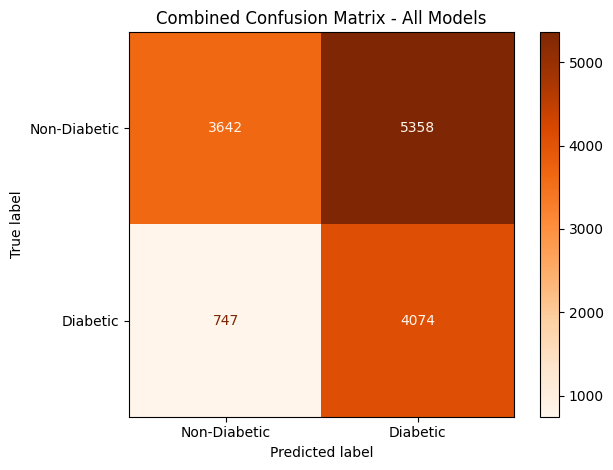


✅ Combined confusion matrix summary saved to: /Users/shadmansakib/Documents/Diabetes_Prediction/Diabetes_Prediction/combined_confusion_matrix_summary.csv


In [8]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Base path and true labels
base_path = "/Users/shadmansakib/Documents/Diabetes_Prediction/Diabetes_Prediction"
ground_truth_df = pd.read_csv(os.path.join(base_path, "diabetes.csv"))
true_labels = ground_truth_df["Outcome"].values

# All model prediction paths
prediction_paths = [
    "models/mistral/diabetes_predictions_mistral_one_shot.csv",
    "models/mistral/diabetes_predictions_mistral_three_shot.csv",
    "models/mistral/diabetes_predictions_mistral_zero_shot.csv",
    "models/llama3.2/diabetes_predictions_llama3.2_zero_shot.csv",
    "models/llama3.2/diabetes_predictions_llama3.2_three_shot.csv",
    "models/llama3.2/diabetes_predictions_llama3.2_one_shot.csv",
    "models/llama3.1/diabetes_predictions_llama3.1_zero_shot.csv",
    "models/llama3.1/diabetes_predictions_llama3.1_three_shot.csv",
    "models/llama3.1/diabetes_predictions_llama3.1_one_shot.csv",
    "models/gemma/diabetes_predictions_gemma2_zero_shot.csv",
    "models/gemma/diabetes_predictions_gemma2_three_shot.csv",
    "models/gemma/diabetes_predictions_gemma2_one_shot.csv",
    "models/gemini/diabetes_predictions_gemini_zero_shot.csv",
    "models/gemini/diabetes_predictions_gemini_three_shot.csv",
    "models/gemini/diabetes_predictions_gemini_one_shot.csv",
    "models/chatgpt/diabetes_predictions_chatgpt_three_shot.csv",
    "models/chatgpt/diabetes_predictions_chatgpt_zero_shot.csv",
    "models/chatgpt/diabetes_predictions_chatgpt_one_shot.csv",
]

# Initialize lists for all predictions and truths
all_preds = []
all_trues = []

# Process and aggregate predictions
for rel_path in prediction_paths:
    full_path = os.path.join(base_path, rel_path)
    model_name = os.path.basename(full_path).replace(".csv", "")

    try:
        pred_df = pd.read_csv(full_path)
        pred_labels = pred_df["Predicted_Outcome"].astype(int).values
    except Exception as e:
        print(f"[ERROR] Skipping {model_name}: {e}")
        continue

    if len(pred_labels) != len(true_labels):
        print(f"[WARN] Skipping {model_name}: Length mismatch")
        continue

    all_preds.extend(pred_labels)
    all_trues.extend(true_labels)  # repeat true labels for each model

# Compute the combined confusion matrix
cm = confusion_matrix(all_trues, all_preds, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

# Display results
print("\n=== Combined Confusion Matrix (All Models) ===")
print(cm)

# Show one heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Diabetic", "Diabetic"])
disp.plot(cmap="Oranges")
plt.title("Combined Confusion Matrix - All Models")
plt.tight_layout()
plt.show()

# Save confusion matrix summary as CSV
summary = pd.DataFrame([{
    "Total True Positives": tp,
    "Total False Positives": fp,
    "Total True Negatives": tn,
    "Total False Negatives": fn
}])
summary_path = os.path.join(base_path, "combined_confusion_matrix_summary.csv")
summary.to_csv(summary_path, index=False)
print(f"\n✅ Combined confusion matrix summary saved to: {summary_path}")
